In [1]:
# keras module for building LSTM 
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 

# set seeds for reproducability
import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

2023-02-02 22:41:52.697451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jlb638/cuda/lib64:/home/jlb638/packages/gdb/lib:/home/jlb638/packages/gcc/lib64:/home/jlb638/packages/gcc/lib:/home/jlb638/packages/gmp/5_0_2/include:/home/jlb638/packages/gmp/5_0_2/lib:/home/jlb638/texinfo/6_6/lib:/home/jlb638/gc563/python/3.9.6/lib:/home/jlb638/cuda/lib64:/home/jlb638/packages/gdb/lib:/home/jlb638/packages/gcc/lib64:/home/jlb638/packages/gcc/lib:/home/jlb638/packages/gmp/5_0_2/include:/home/jlb638/packages/gmp/5_0_2/lib:/home/jlb638/texinfo/6_6/lib:/home/jlb638/gc563/python/3.9.6/lib:
2023-02-02 22:41:52.697572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from mnist_dijk import *

In [44]:
from datasets import load_dataset
big_dataset = load_dataset("jlbaker361/mnist_dijkstra_v0.0")

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 228.12it/s]


Dataset parquet downloaded and prepared to /home/jlb638/.cache/huggingface/datasets/jlbaker361___parquet/jlbaker361--mnist_dijkstra_v0.0-7c506d7590f9f055/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


In [45]:
big_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'sequence', 'occurence', 'split'],
        num_rows: 68533
    })
})

In [3]:
small_dataset=make_dataset(50)

2023-02-02 22:42:28.441374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jlb638/cuda/lib64:/home/jlb638/packages/gdb/lib:/home/jlb638/packages/gcc/lib64:/home/jlb638/packages/gcc/lib:/home/jlb638/packages/gmp/5_0_2/include:/home/jlb638/packages/gmp/5_0_2/lib:/home/jlb638/texinfo/6_6/lib:/home/jlb638/gc563/python/3.9.6/lib:/home/jlb638/cuda/lib64:/home/jlb638/packages/gdb/lib:/home/jlb638/packages/gcc/lib64:/home/jlb638/packages/gcc/lib:/home/jlb638/packages/gmp/5_0_2/include:/home/jlb638/packages/gmp/5_0_2/lib:/home/jlb638/texinfo/6_6/lib:/home/jlb638/gc563/python/3.9.6/lib:
2023-02-02 22:42:28.441533: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-02 22:42:28.441604: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be

In [4]:
small_dataset

Dataset({
    features: ['label', 'sequence', 'occurence', 'split'],
    num_rows: 99
})

In [5]:
len(small_dataset['sequence'])

99

In [6]:
def get_sequence_of_tokens(corpus):
    all_input_sequences = []
    all_words=set()
    for token_list in corpus:
        all_words.add(token_list[0])
        all_words.add(token_list[-1])
        for t in range(1, len(token_list)-1):
            all_words.add(token_list[t])
            n_gram_sequence = token_list[:t+1]
            all_input_sequences.append(n_gram_sequence)

    return all_input_sequences, len(all_words)



In [7]:
inp_sequences, total_words = get_sequence_of_tokens(small_dataset['sequence'])

In [8]:
inp_sequences[:10]

[[157, 158],
 [157, 158, 159],
 [157, 158, 159, 185],
 [157, 158, 159, 185, 186],
 [157, 158, 159, 185, 186, 187],
 [157, 158, 159, 185, 186, 187, 212],
 [157, 158, 159, 185, 186, 187, 212, 213],
 [157, 158, 159, 185, 186, 187, 212, 213, 214],
 [157, 158, 159, 185, 186, 187, 212, 213, 214, 215],
 [157, 158, 159, 185, 186, 187, 212, 213, 214, 215, 233]]

In [9]:
def to_category(token,total_words): #token is number < total_words +1
    arr=np.zeros(total_words)
    arr[token]=1
    return arr


def generate_padded_sequences(input_sequences,total_words=28*28):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre', value=0))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = np.array([to_category(l,total_words) for l in label])
    return predictors, label, max_sequence_len

In [10]:
predictors, label, max_sequence_len=generate_padded_sequences(inp_sequences)

In [11]:
predictors[:10]

array([[  0,   0,   0, ...,   0,   0, 157],
       [  0,   0,   0, ...,   0, 157, 158],
       [  0,   0,   0, ..., 157, 158, 159],
       ...,
       [  0,   0,   0, ..., 187, 212, 213],
       [  0,   0,   0, ..., 212, 213, 214],
       [  0,   0,   0, ..., 213, 214, 215]], dtype=int32)

In [12]:
label[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [13]:
def create_model(max_sequence_len, total_words=28*28):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 10)           7840      
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 784)               79184     
                                                                 
Total params: 131,424
Trainable params: 131,424
Non-trainable params: 0
_________________________________________________________________


In [14]:
np.shape(predictors)

(15221, 280)

In [15]:
np.shape(label)

(15221, 784)

In [17]:
model.fit(predictors, label, epochs=1, verbose=5)

In [38]:
def generate_text(initial_sequence, length, model, max_sequence_len):
    current_sequence= initial_sequence
    for _ in range(length):
        print(current_sequence)
        padded=np.array(pad_sequences([current_sequence], maxlen=max_sequence_len-1, padding='pre')).astype(int)
        token=np.argmax(model(padded))
        current_sequence.append(token)
    return current_sequence


In [40]:
generate_text([100,128,101], 3,model,max_sequence_len)

[100, 128, 101]
[100, 128, 101, 126]
[100, 128, 101, 126, 126]


[100, 128, 101, 126, 126, 126]

In [41]:
def sequence_to_image(sequence,dim=28):
    empty_c=[[0.0 for _ in range(dim)] for __ in range(dim)]
    for token in sequence:
        (vert,horiz)=num_to_coords(token)
        empty_c[vert][horiz]=1
    return empty_c


In [42]:
import matplotlib.pyplot as plt

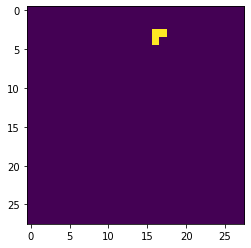

In [43]:
plt.imshow(sequence_to_image([100,101,128]))